## Homework

### Dataset

In this homework, we will use the California Housing Prices. You can take it from
[Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

### EDA

* Load the data.
* Look at the `median_house_value` variable. Does it have a long tail? 
> Yes, it does have a tail. Not the textbook definition though.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

<AxesSubplot:>

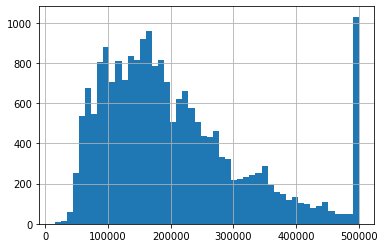

In [6]:
df['median_house_value'].hist(bins=50)

### Features

For the rest of the homework, you'll need to use only these columns:

* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`

Select only them.

In [7]:
df = df.drop(['ocean_proximity'], axis=1)

In [9]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

### Question 1

Find a feature with missing values. How many missing values does it have?
- **207** - total_bedrooms
- 307
- 408
- 508

In [11]:
# Find a feature with missing values. How many missing values does it have?
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2

What's the median (50% percentile) for variable 'population'?
- 1133
- 1122
- **1166**
- 1188

In [12]:
df['population'].median()

1166.0

### Split the data

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('median_house_value') is not in your dataframe.
* Apply the log transformation to the median_house_value variable using the `np.log1p()` function.

In [19]:
train_len = int(0.6 * len(df))
val_len = int(0.2 * len(df))
test_len = len(df) - train_len - val_len

In [20]:
train_len, val_len, test_len

(12384, 4128, 4128)

In [32]:
np.random.seed(42)
idx = np.arange(len(df))
np.random.shuffle(idx)

In [35]:
df_train = df.iloc[idx[:train_len]].reset_index(drop=True)
df_val = df.iloc[idx[train_len:train_len+val_len]].reset_index(drop=True)
df_test = df.iloc[idx[train_len+val_len:]].reset_index(drop=True)

In [36]:
df_train.shape, df_val.shape, df_test.shape

((12384, 9), (4128, 9), (4128, 9))

In [38]:
y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

In [56]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:
- With 0
- With mean
- With median
- **Both are equally good**

In [60]:
base = ['longitude', 'latitude', 'housing_median_age', 'total_rooms','total_bedrooms', 'population', 'households', 'median_income',]

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def prepare_X(df, fill_na):
    df_num = df[base]
    df_num = df_num.fillna(fill_na)
    X = df_num.values
    return X

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [67]:
# Impute with 0
X_train_zero = prepare_X(df_train, fill_na=0)
X_val_zero = prepare_X(df_val, fill_na=0)
w_0, w = train_linear_regression(X_train_zero, y_train)

y_pred_zero = w_0 + X_val_zero.dot(w)
round(rmse(y_val, y_pred_zero),2)

0.33

In [68]:
# Impute with mean
X_train_mean = prepare_X(df_train, fill_na=df_train['total_bedrooms'].mean())
X_val_mean = prepare_X(df_val, fill_na=df_train['total_bedrooms'].mean())
w_0, w = train_linear_regression(X_train_mean, y_train)

y_pred_mean = w_0 + X_val_mean.dot(w)
round(rmse(y_val, y_pred_mean),2)

0.33

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:
- **0**
- 0.000001
- 0.001
- 0.0001

In [63]:

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [70]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train_zero, y_train, r=r)
    y_pred_val_reg = w_0 + X_val_zero.dot(w)
    rmse_val = np.round(rmse(y_val, y_pred_val_reg),2)
    print(r, w_0, rmse_val)


0 -11.686975242036546 0.33
1e-06 -11.686959175728921 0.33
0.0001 -11.685368865034667 0.33
0.001 -11.670931317799797 0.33
0.01 -11.528493585632091 0.33
0.1 -10.274500282195673 0.33
1 -4.920480897742212 0.33
5 -1.482095745621172 0.34
10 -0.7899311831779245 0.34


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

Options:
- 0.16
- 0.00005
- **0.005**
- 0.15555

In [88]:
def prepare_datasets(seed_val, delete_target = True):
    train_len = int(0.6 * len(df))
    val_len = int(0.2 * len(df))
    test_len = len(df) - train_len - val_len
    np.random.seed(seed_val)
    idx = np.arange(len(df))
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:train_len]].reset_index(drop=True)
    df_val = df.iloc[idx[train_len:train_len+val_len]].reset_index(drop=True)
    df_test = df.iloc[idx[train_len+val_len:]].reset_index(drop=True)

    y_train = np.log1p(df_train['median_house_value'].values)
    y_val = np.log1p(df_val['median_house_value'].values)
    y_test = np.log1p(df_test['median_house_value'].values)
    if delete_target:
        del df_train['median_house_value']
        del df_val['median_house_value']
        del df_test['median_house_value']
    
    return df_train, df_val, df_test, y_train, y_val, y_test

In [89]:
rmse_scores = []
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, df_val, df_test, y_train, y_val, y_test = prepare_datasets(i, delete_target=True)
    # Impute with 0
    X_train_zero = prepare_X(df_train, fill_na=0)
    X_val_zero = prepare_X(df_val, fill_na=0)
    w_0, w = train_linear_regression(X_train_zero, y_train)

    y_pred_zero = w_0 + X_val_zero.dot(w)
    rmse_scores.append(round(rmse(y_val, y_pred_zero),2))
    

In [90]:
round(np.std(rmse_scores),3)

0.005

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:
- **0.35**
- 0.135
- 0.450
- 0.245

In [91]:
df_train, df_val, df_test, y_train, y_val, y_test = prepare_datasets(9, delete_target=False)
df_train = df_train.append(df_val, ignore_index = True)


In [93]:
y_train = df_train['median_house_value'].values
y_test = df_test['median_house_value'].values

In [94]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

del df_train['median_house_value']
del df_test['median_house_value']

In [95]:
# Impute with 0
X_train_zero = prepare_X(df_train, fill_na=0)
X_test_zero = prepare_X(df_test, fill_na=0)
w_0, w = train_linear_regression_reg(X_train_zero, y_train, r=0.001)

y_pred_test_reg = w_0 + X_test_zero.dot(w)
rmse_test = np.round(rmse(y_test, y_pred_test_reg),2)
print(rmse_test)

0.35
